In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns
from collections import defaultdict
from sequencing_tools.viz_tools import okabeito_palette, \
                        simpsons_palette, \
                        RNA_base_from_picard, \
                        RNA_cov_from_picard, \
                        color_encoder
from collections import defaultdict
import re
import glob
import os
from plotting_utils import label_sample, rename_sample, \
                        label_ce, rna_type_ce, \
                        figure_path
from count_plot import plot_insert, plot_coding_bases, plot_strand, plot_count, sample_wise_fraction

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# insert size

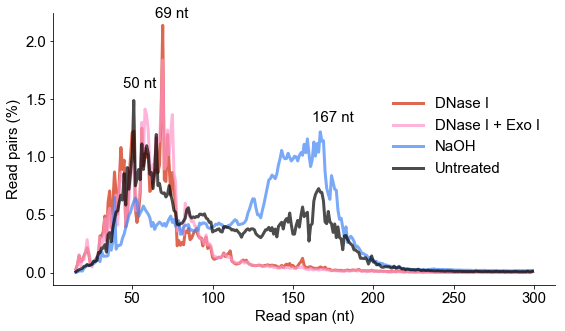

In [11]:
fig = plt.figure(figsize = (9,5))
ax_insert = fig.add_subplot(111)
idf = plot_insert(ax_insert, samples = ['DNase I', 'DNase I + Exo I',
                                       'NaOH', 'Untreated', 'Unfragmented'])#,
                                     # "DNase I - 3'P" ])
sns.despine()
#ax_insert.set_ylim(0,2)
ax_insert.text(64, 2.2, '69 nt', fontsize=15)
ax_insert.text(44, 1.6, '50 nt', fontsize=15)
ax_insert.text(162, 1.3, '167 nt', fontsize=15)

fig.savefig(figure_path + '/insert_plots.pdf', bbox_inches = 'tight')

In [12]:
idf.groupby('label').apply(lambda d: d[d.size_fraction==d.size_fraction.max()])

,,label,isize,size_fraction
label,,,,
DNase I,3751,DNase I,69,2.137538
DNase I + Exo I,623,DNase I + Exo I,69,1.838563
NaOH,152,NaOH,167,1.217203
Untreated,4018,Untreated,51,1.487837


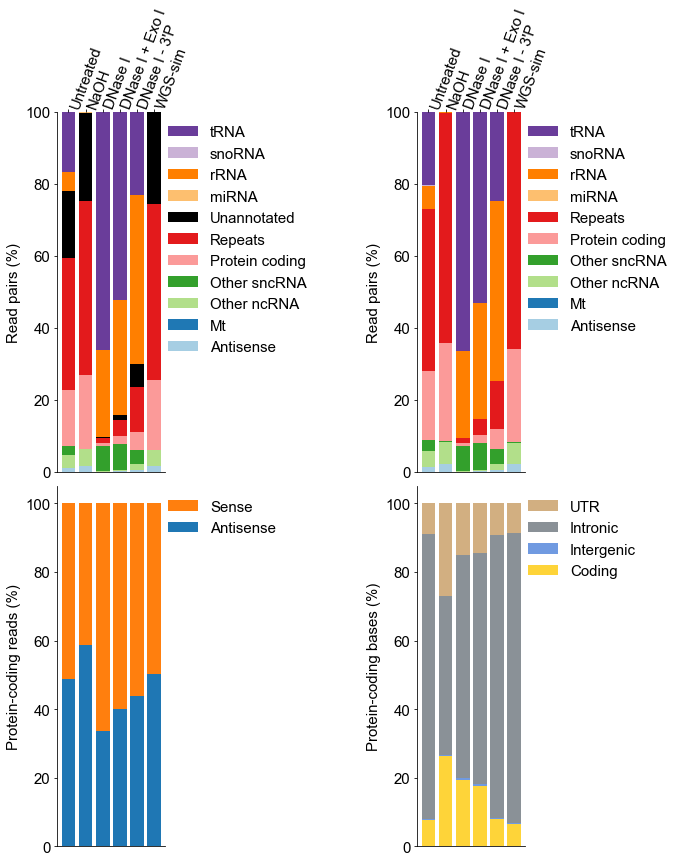

In [23]:
#fig = plt.figure(figsize = (10,8))
#ax_frag_dist = fig.add_axes([0,0,0.15,0.5])
#ax_frag_dist_feature_only = fig.add_axes([0.5,0,0.15,0.5])
#ax_strand = fig.add_axes([1,0,0.15,0.5])
#ax_coding = fig.add_axes([1.4,0,0.15,0.5])

fig = plt.figure(figsize = (10,10))
ax_frag_dist = fig.add_axes([0,0.52,0.15,0.5])
ax_frag_dist_feature_only = fig.add_axes([0.5,0.52,0.15,0.5])
ax_strand = fig.add_axes([0,0,0.15,0.5])
ax_coding = fig.add_axes([0.5,0, 0.15, 0.5])


cdf = plot_count(ax_frag_dist, feature_only=False)
cdf = plot_count(ax_frag_dist_feature_only, feature_only=True)
plot_strand(ax_strand)
plot_coding_bases(ax_coding)
ax_strand.xaxis.set_visible(False)
ax_coding.xaxis.set_visible(False)
ax_frag_dist.xaxis.tick_top()
ax_frag_dist_feature_only.xaxis.tick_top()
#fig.tight_layout()
fig.savefig(figure_path + '/fragment_plots.pdf', bbox_inches = 'tight')

In [30]:
from collections import defaultdict
dedup_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.feather')
cor_df = np.log(dedup_df\
                .filter(regex = 'Qcf|QCF')\
                .filter(regex="dedup:sense") \
                .pipe(lambda d: d+1))

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [32]:
pd.DataFrame({'a':cor_df.columns, 'b':rename_sample(cor_df.columns)})

,a,b
0,QCF1_R1_001:dedup:sense,DNase I 1
1,QCF2_R1_001:dedup:sense,DNase I 2
2,Qcf10_R1_001:dedup:sense,DNase I 3
3,Qcf11_R1_001:dedup:sense,DNase I 4
4,Qcf12_R1_001:dedup:sense,DNase I 5
5,Qcf13_R1_001:dedup:sense,DNase I 6
6,Qcf4_R1_001:dedup:sense,DNase I 7
7,Qcf5_R1_001:dedup:sense,DNase I 8
8,Qcf6_SS_R1_001:dedup:sense,DNase I 9
9,Qcf7_R1_001:dedup:sense,DNase I 10


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


Text(0.1,0.86,"Pearson's $\\rho$")

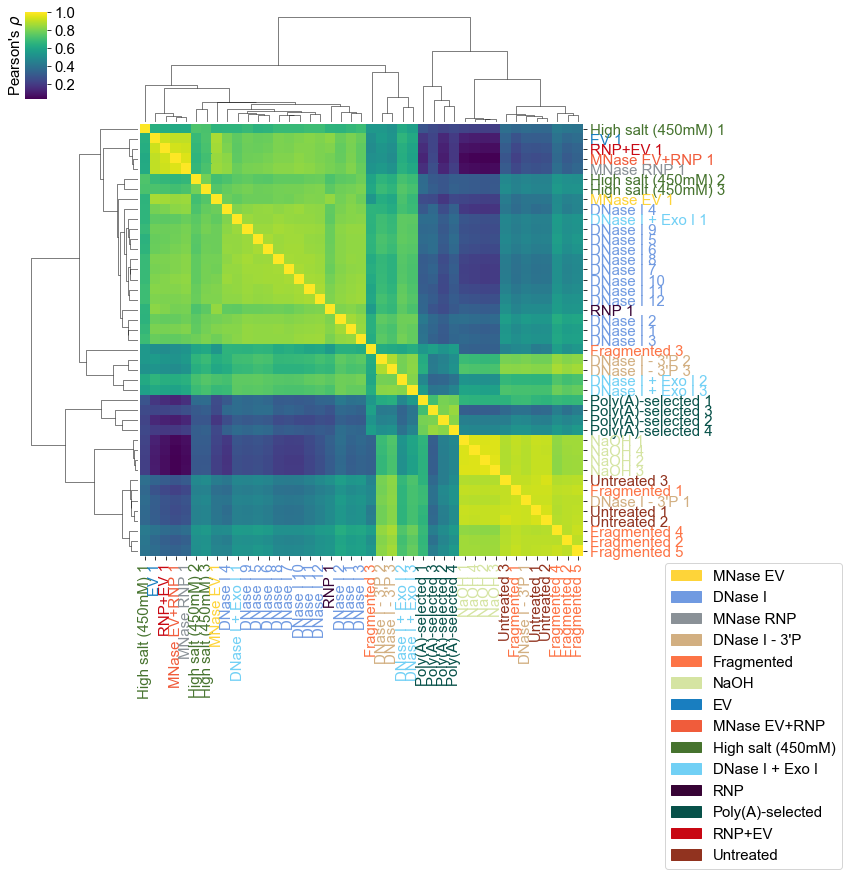

In [35]:
from collections import defaultdict
dedup_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.feather')
cor_df = np.log(dedup_df\
                .filter(regex = 'Qcf|QCF|PP|MP')\
                .filter(regex="dedup:sense") \
                .pipe(lambda d: d[d.columns[~d.columns.str.contains('LE[0-9]+')]])\
                .pipe(lambda d: d+1))
cor_df.columns = rename_sample(cor_df.columns)
cor_df = cor_df.corr(method='pearson')
p = sns.clustermap(cor_df, cmap = 'viridis')
ax = p.ax_heatmap
xt = ax.set_xticks(range(cor_df.shape[0]))
yt = ax.set_yticks(range(cor_df.shape[1]))
xt = ax.set_xticklabels(cor_df.columns[p.dendrogram_col.reordered_ind])
yt = ax.set_yticklabels(cor_df.index[p.dendrogram_row.reordered_ind])

yt = ax.set_yticks(np.arange(cor_df.shape[1])+0.5)
xt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)

ce = color_encoder()
ce.fit(cor_df.columns.str.replace(' [0-9]+$',''), 
                 simpsons_palette())
for xt in ax.get_xmajorticklabels():
    color = ce.encoder[re.sub(' [0-9]+$','', xt.get_text())]
    xt.set_color(color)
    
for yt in ax.get_ymajorticklabels():
    color = ce.encoder[re.sub(' [0-9]+$','', yt.get_text())]
    yt.set_color(color)

pat = [mpatches.Patch(color=col, label=lab) for lab, col in ce.encoder.items()]
ax.legend(handles=pat, bbox_to_anchor = (1.6,0.), fontsize=15)
p.fig.text(0.1, 0.86, r"Pearson's $\rho$", rotation = 90, fontsize=15)

In [27]:
strand_df = {os.path.basename(metric).split('.')[0]: read_metric(metric) for metric in metrics}
pd.concat([d.assign(samplename = k) for k, d in strand_df.items()])\
        .pipe(lambda d: d[d.samplename.str.contains('unf|[Aa]lka')])\
        .assign(samplename = lambda d: np.where(d.samplename.str.contains('[aA]lka'),'Alkaline\nhydrolysis','DNase\ntreated'))\
        .assign(variable = lambda d: np.where(d.variable.str.contains('R1'), 'Sense strand','Antisense-strand'))\
        .assign(value = lambda d: d['value'] * 100)\
        .pipe(pd.pivot_table, index='samplename', columns = 'variable', values = 'value')

NameError: name 'metrics' is not defined

In [100]:
RNA_base_from_picard(metrics) \
    .pipe(lambda d: d[d.samplename.str.contains('unfr|alka')]) \
    .assign(var_count = lambda d: d.var_count*100)\
    .assign(samplename = lambda d: np.where(d.samplename.str.contains('[Aa]lk'), 'Alkaline hydrolysis', 'DNase-treated'))\
    .pipe(pd.pivot_table, columns = 'variable', index='samplename', values = 'var_count')

variable,Coding bases,Intergenic bases,Intronic bases,Utr bases
samplename,,,,
Alkaline hydrolysis,7.9500,0.2839,82.8769,8.8892
DNase-treated,19.4209,0.6379,64.7821,15.1590


In [12]:
dedup_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.feather')


filter_feature = 'No features' 
dedup_regex = ':dedup:' 
dedup_df \
        .filter(regex = 'type|Qcf|QCF|sim')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains('Y-RNA'), 'Other sncRNA', d.grouped_type))\
        .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains("vaultRNA|VT|vt"),'Vault RNA', d.grouped_type))\
        .groupby('grouped_type')\
        .sum() \
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains(dedup_regex)]]) \
        .reset_index()\
        .pipe(pd.melt, id_vars = ['grouped_type']) \
        .assign(variable = lambda d: d.variable.str.split(':', expand=True).iloc[:,0])\
        .assign(treatment = lambda d: d.variable.map(label_sample)) \
        .groupby(['variable','grouped_type','treatment'], as_index=False)\
        .agg({'value':'sum'}) \
        .query('grouped_type != "%s"' %filter_feature)\
        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre|sim')])\
        .assign(value = lambda d: d.groupby('treatment')['value'].transform(lambda x: 100*x/x.sum()))  \
        .query('treatment == "DNase I + Phosphatase" & grouped_type == "rRNA"')

,variable,grouped_type,treatment,value
347,Qcf_Phos1_R1_001,rRNA,DNase I + Phosphatase,18.444949
357,Qcf_Phos2_R1_001,rRNA,DNase I + Phosphatase,13.828251
367,Qcf_Phos3_R1_001,rRNA,DNase I + Phosphatase,17.671099


In [111]:
def plot_count_with_genome(ax):
    dedup_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.feather')


    countplot_df = dedup_df \
        .filter(regex = 'type|Qcf|QCF')\
        .assign(grouped_type = lambda d: np.where(d.grouped_type == "rDNA", 'rRNA', d.grouped_type))\
        .groupby('grouped_type')\
        .sum() \
        .pipe(lambda d: d[d.columns[~d.columns.str.contains('anti')]])\
        .pipe(lambda d: d[d.columns[d.columns.str.contains('dedup')]]) \
        .reset_index()\
        .pipe(pd.melt, id_vars = ['grouped_type']) \
        .assign(treatment = lambda d: d.variable.map(label_sample)) \
        .groupby(['grouped_type','treatment'], as_index=False)\
        .agg({'value':'sum'}) \
        .pipe(lambda d: d[d.treatment.str.contains('Exo|Na|DN|Untre')])\
        .assign(value = lambda d: d.groupby('treatment')['value'].transform(lambda x: 100*x/x.sum()))\
        .pipe(pd.pivot_table, index = 'treatment', 
             columns = 'grouped_type',
             values = 'value')\
        .reset_index() \
        .sort_values('treatment')\
        .set_index('treatment')\
        .pipe(lambda d: d.reindex(sorted(d.columns), axis=1))
    
    colors = rna_type_ce.transform(countplot_df.columns)
    countplot_df\
        .pipe(lambda d: pd.concat([d, genome_rna()], sort=True))\
        .reindex(index=np.append('Genome', label_order))\
        .plot\
        .bar(stacked=True, 
             color = colors, 
              ax = ax,
             width = 0.8)
    xt = [xt.set_text(xt.get_text()) for xt in ax.get_xticklabels()]
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right')
    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], 
              bbox_to_anchor = (1,1), fontsize = 15,
             frameon=False)
    ax.set_xlabel('')
    ax.set_ylabel('Read pairs (%)')
    sns.despine()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


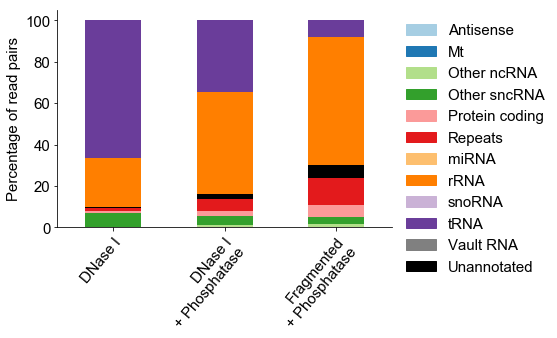

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
tdf = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/all_counts/spreaded_all_counts.feather') \
    .filter(regex='grouped|Q[cC][fF][0-9]+|[Ff]rag|[pP]hos') \
    .pipe(lambda d: d[d.columns[~d.columns.str.contains('Phos1')]])\
    .assign(grouped_type = lambda d: np.where(d.grouped_type.str.contains('No features'), 'Unannotated', d.grouped_type))\
    .groupby('grouped_type', as_index=False)\
    .sum()\
    .pipe(pd.melt, id_vars = 'grouped_type', 
          var_name = 'samplename', value_name = 'read_count')\
    .pipe(lambda d: d[d.samplename.str.contains('dedup:sense')]) \
    .assign(label = lambda d: d.samplename.map(label_sample))\
    .assign(label = lambda d: np.where(d.label.str.contains('^Fragmen'), d.label + ' + Phosphatase',d.label))\
    .assign(label = lambda d: d.label.str.replace(' \+ ','\n+ '))\
    .groupby(['label','grouped_type'], as_index=False)\
    .agg({'read_count':'sum'})\
    .assign(read_count = lambda d: d.groupby('label')['read_count'].transform(lambda x: 100*x/x.sum()))\
    .pipe(pd.pivot_table, index='label', columns = 'grouped_type', values = 'read_count')
tdf.plot.bar(stacked=True, colors = list(map(lambda x: rna_type_ce.encoder[x],tdf.columns.values)), ax = ax)
rna_type_ce.show_legend(ax, frameon=False, bbox_to_anchor = (1,1), fontsize=15)
sns.despine()
ax.set_xlabel('')
xt = ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha ='right', rotation_mode = 'anchor')
ax.set_ylabel('Percentage of read pairs')
fig.savefig(figure_path + '/count_phos_frag.png', bbox_inches = 'tight')

In [39]:
s = sample_wise_fraction()
s.label.unique()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


array(['DNase I', 'DNase I + Exo I', 'DNase I + Phosphatase',
       'Fragmented', 'High salt (450mM)', 'NaOH', 'Poly(A)-selected',
       'Untreated', 'WGS-sim'], dtype=object)

In [42]:
s.pipe(lambda d: d[d.label == "DNase I"])

label    grouped_type      rfrac           
                                  min        max
0  DNase I       Antisense   0.014871   0.050933
1  DNase I     No features   0.129718   0.783100
2  DNase I     Other ncRNA   0.110196   0.258444
3  DNase I    Other sncRNA   5.678822   9.123290
4  DNase I  Protein coding   0.262457   1.487154
5  DNase I         Repeats   0.808522   1.942869
6  DNase I           miRNA   0.005190   0.025332
7  DNase I            rRNA  14.870571  41.453659
8  DNase I          snoRNA   0.009723   0.032585
9  DNase I            tRNA  46.288310  75.505953

In [5]:
dedup_df.query('gene_type=="rRNA"')

NameError: name 'dedup_df' is not defined